In [2]:
# Import necessary PySpark modules
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.appName("KickstarterAnalysis").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/07 05:39:26 INFO SparkEnv: Registering MapOutputTracker
23/12/07 05:39:26 INFO SparkEnv: Registering BlockManagerMaster
23/12/07 05:39:26 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
23/12/07 05:39:26 INFO SparkEnv: Registering OutputCommitCoordinator


In [3]:
# Load the dataset
ks0 = spark.read.csv("gs://hivestoragesky/Updatedtable.csv", header=True, inferSchema=True)

In [4]:
# Print the structure of the dataset
ks0.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- category: string (nullable = true)
 |-- main_category: string (nullable = true)
 |-- currency: string (nullable = true)
 |-- deadline: string (nullable = true)
 |-- deadline_year: string (nullable = true)
 |-- deadline_month: string (nullable = true)
 |-- deadline_day: string (nullable = true)
 |-- goal: string (nullable = true)
 |-- launched: string (nullable = true)
 |-- launched_year: string (nullable = true)
 |-- launched_month: string (nullable = true)
 |-- launched_day: string (nullable = true)
 |-- pledged: string (nullable = true)
 |-- state: string (nullable = true)
 |-- backers: string (nullable = true)
 |-- country: string (nullable = true)
 |-- usd pledged: string (nullable = true)



In [7]:
from pyspark.sql.functions import col, format_number
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import to_timestamp, year, month, dayofmonth

# Convert relevant columns to numeric, handle missing values
ks0 = ks0.withColumn("pledged", col("pledged").cast(DoubleType())).na.fill(0)
ks0 = ks0.withColumn("goal", col("goal").cast(DoubleType())).na.fill(0)

# Escape column name with backticks
ks0 = ks0.withColumn("usd.pledged", col("`usd pledged`").cast(DoubleType())).na.fill(0)

ks0 = ks0.withColumn("backers", col("backers").cast(DoubleType())).na.fill(0)

# Convert string columns to timestamp
ks0 = ks0.withColumn("deadline", to_timestamp(col("deadline"), "yyyy-MM-dd HH:mm:ss"))
ks0 = ks0.withColumn("launched", to_timestamp(col("launched"), "yyyy-MM-dd HH:mm:ss"))

# xtract year, month, and day from the timestamp columns 
ks0 = ks0.withColumn("deadline_year", year(col("deadline")))
ks0 = ks0.withColumn("deadline_month", month(col("deadline")))
ks0 = ks0.withColumn("deadline_day", dayofmonth(col("deadline")))

ks0 = ks0.withColumn("launched_year", year(col("launched")))
ks0 = ks0.withColumn("launched_month", month(col("launched")))
ks0 = ks0.withColumn("launched_day", dayofmonth(col("launched")))


In [8]:
# Print the structure of the dataset
ks0.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- category: string (nullable = true)
 |-- main_category: string (nullable = true)
 |-- currency: string (nullable = true)
 |-- deadline: timestamp (nullable = true)
 |-- deadline_year: integer (nullable = true)
 |-- deadline_month: integer (nullable = true)
 |-- deadline_day: integer (nullable = true)
 |-- goal: double (nullable = false)
 |-- launched: timestamp (nullable = true)
 |-- launched_year: integer (nullable = true)
 |-- launched_month: integer (nullable = true)
 |-- launched_day: integer (nullable = true)
 |-- pledged: double (nullable = false)
 |-- state: string (nullable = true)
 |-- backers: double (nullable = false)
 |-- country: string (nullable = true)
 |-- usd pledged: string (nullable = true)
 |-- usd.pledged: double (nullable = false)



In [9]:
from pyspark.sql.functions import col, year, to_timestamp

# Extract the year from the 'launched' column
ks = ks0.withColumn("launched_year", year(col("launched")))

# Filter out invalid years
ks = ks.filter((col("launched_year") >= 2009) & (col("launched_year") <= 2016) & (col("launched_year").isNotNull()))

# Group by year and select relevant columns for analysis
ksk1 = ks.groupBy("launched_year").agg({"goal": "sum", "pledged": "sum", "backers": "sum"})

# Display the aggregated data
ksk1.show()


+-------------+------------+---------+------------+
|launched_year|sum(backers)|sum(goal)|sum(pledged)|
+-------------+------------+---------+------------+
+-------------+------------+---------+------------+



                                        Popularity of Kickstarter

a) Number of Projects launched on Kickstarter by year

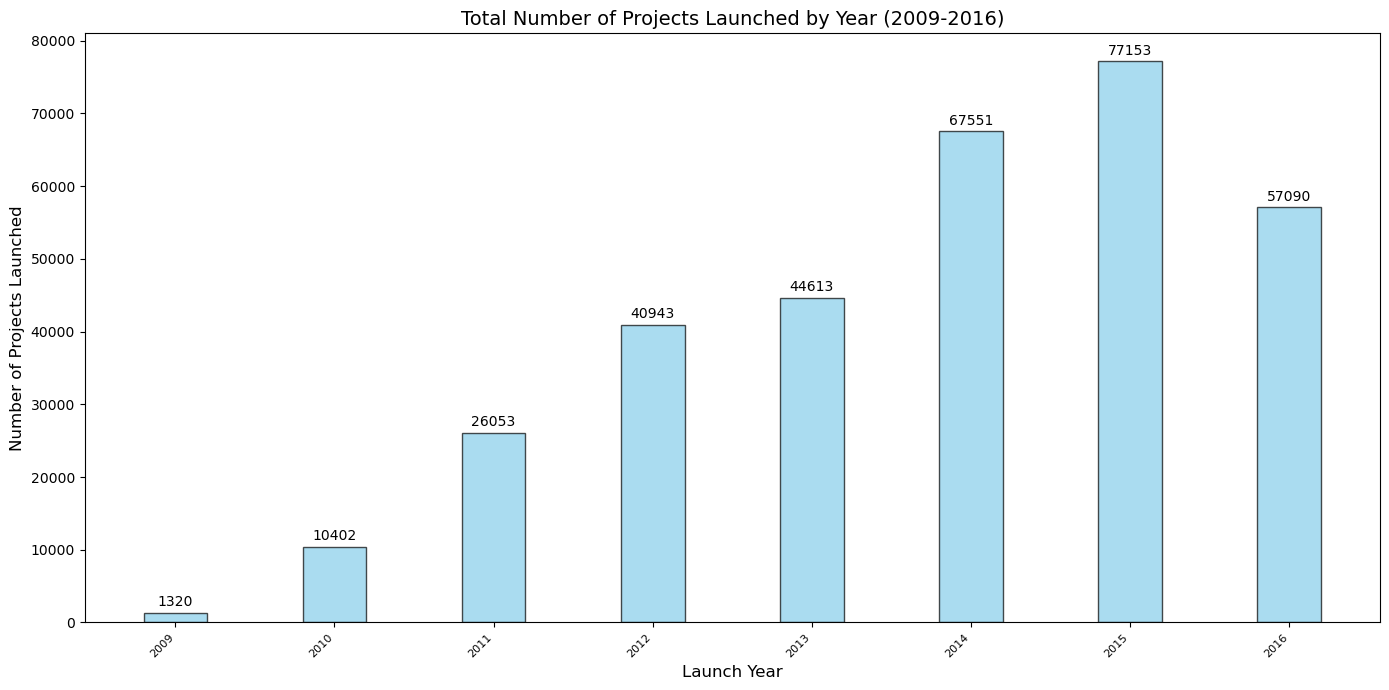

In [21]:
from pyspark.sql.functions import col, year, sum
import matplotlib.pyplot as plt

# Select relevant columns for analysis
ks = ks0.select("state", "main_category", "category", "country", "goal", "pledged", "backers", "launched")

# Extract the year from the 'launched' column
ks = ks.withColumn("launched_year", year(col("launched")))

# Filter out invalid years
ks = ks.filter((col("launched_year") != 1970) & (col("launched_year").isNotNull()))

# Add an additional filter for the years between 2009 and 2016
ks = ks.filter((col("launched_year") >= 2009) & (col("launched_year") <= 2016))

# Group by year and calculate the count of projects
ksk1 = ks.groupBy("launched_year").agg(count("launched").alias("num_projects"))

# Convert to Pandas for visualization
ksk1_pd = ksk1.toPandas()

# Plotting using Matplotlib
plt.figure(figsize=(14, 7))
bar_width = 0.4

plt.bar(ksk1_pd['launched_year'], ksk1_pd['num_projects'], color='skyblue', width=bar_width, edgecolor='black', alpha=0.7)

# Add data labels
for i, value in enumerate(ksk1_pd['num_projects']):
    plt.text(ksk1_pd['launched_year'][i], value + 500, f'{value}', ha='center', va='bottom')

plt.xticks(ksk1_pd['launched_year'], rotation=45, ha='right', fontsize=8)
plt.xlabel('Launch Year', fontsize=12)
plt.ylabel('Number of Projects Launched', fontsize=12)
plt.title('Total Number of Projects Launched by Year (2009-2016)', fontsize=14)
plt.tight_layout()
plt.show()


b) Successful Project% on Kickstarter by year

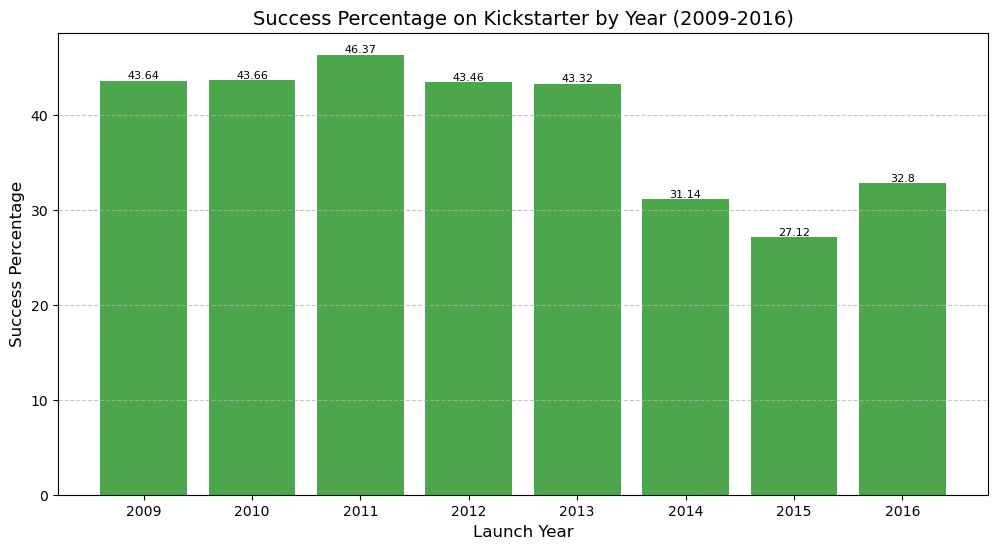

In [7]:
from pyspark.sql.functions import year

# Select relevant columns for analysis
ks = ks0.select("state", "launched")

# Extract the year from the 'launched' column
ks = ks.withColumn("launched_year", year("launched"))

# Filter out invalid years
ks = ks.filter((ks["launched_year"] != 1970) & ks["launched_year"].isNotNull())

# Add an additional filter for the years between 2009 and 2016
ks = ks.filter((ks["launched_year"] >= 2009) & (ks["launched_year"] <= 2016))

# Calculate the success percentage by year
success_percentage = (
    ks.filter(ks["state"] == "successful")
    .groupBy("launched_year")
    .count()
    .withColumnRenamed("count", "successful_projects")
)
total_projects = ks.groupBy("launched_year").count().withColumnRenamed("count", "total_projects")

success_percentage = (
    success_percentage.join(total_projects, "launched_year", "inner")
    .withColumn("success_percentage", (success_percentage["successful_projects"] / total_projects["total_projects"]) * 100)
    .select("launched_year", "success_percentage")
)

# Convert to Pandas for visualization
success_percentage_pd = success_percentage.toPandas()

# Plotting using Matplotlib
plt.figure(figsize=(12, 6))
bars = plt.bar(success_percentage_pd["launched_year"], success_percentage_pd["success_percentage"], color="green", alpha=0.7)

# Add data labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom', fontsize=8)

plt.xlabel("Launch Year", fontsize=12)
plt.ylabel("Success Percentage", fontsize=12)
plt.title("Success Percentage on Kickstarter by Year (2009-2016)", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


c) Money raised (in USD Million) on Kickstarter by year

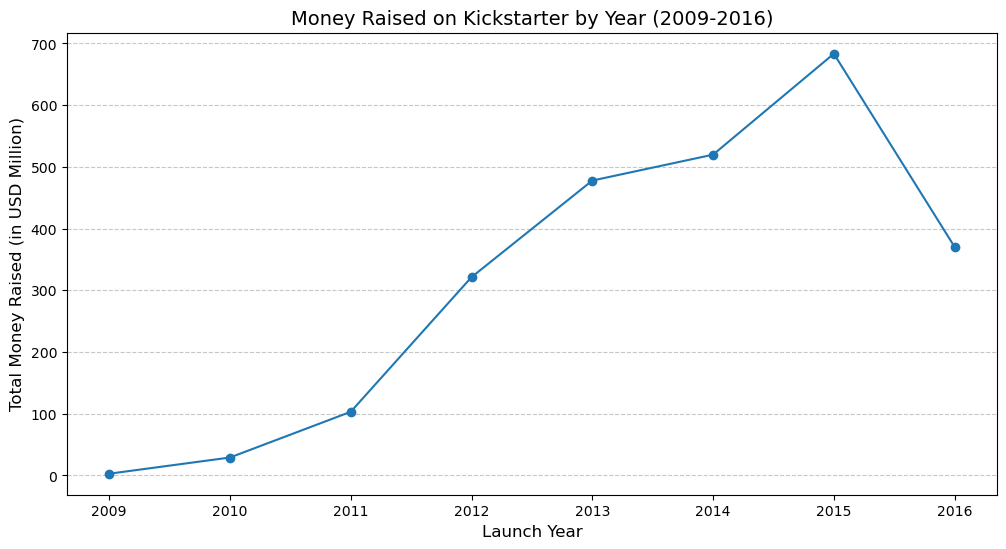

In [9]:
from pyspark.sql.functions import year, sum

# Select relevant columns for analysis
ks = ks0.select("usd pledged", "launched")

# Extract the year from the 'launched' column
ks = ks.withColumn("launched_year", year("launched"))

# Filter out invalid years
ks = ks.filter((ks["launched_year"] != 1970) & ks["launched_year"].isNotNull())

# Add an additional filter for the years between 2009 and 2016
ks = ks.filter((ks["launched_year"] >= 2009) & (ks["launched_year"] <= 2016))

# Calculate the total money raised (in USD Million) by year
money_raised_by_year = (
    ks.groupBy("launched_year")
    .agg((sum("usd pledged") / 1000000).alias("total_money_raised"))
    .orderBy("launched_year")
)

# Convert to Pandas for visualization
money_raised_by_year_pd = money_raised_by_year.toPandas()

# Plotting using Matplotlib
plt.figure(figsize=(12, 6))
plt.plot(money_raised_by_year_pd["launched_year"], money_raised_by_year_pd["total_money_raised"], marker='o', linestyle='-')

plt.xlabel("Launch Year", fontsize=12)
plt.ylabel("Total Money Raised (in USD Million)", fontsize=12)
plt.title("Money Raised on Kickstarter by Year (2009-2016)", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


                            Influence of Category on project success

a) Successful Project% on Kickstarter by Main Category

In [10]:
from pyspark.sql.functions import col, count, when

# Select relevant columns for analysis
ks = ks0.select("main_category", "state")

# Filter out projects with state 'canceled' or 'undefined'
ks = ks.filter(~col("state").isin(["canceled", "undefined"]))

# Calculate the total number of projects and successful projects by main category
project_counts = ks.groupBy("main_category").agg(
    count("*").alias("total_projects"),
    count(when(col("state") == "successful", True)).alias("successful_projects")
)

# Calculate the successful project percentage
project_counts = project_counts.withColumn(
    "success_percentage", 
    (col("successful_projects") / col("total_projects")) * 100
)

# Show the result
project_counts.show(truncate=False)


+-------------------------------------------+--------------+-------------------+------------------+
|main_category                              |total_projects|successful_projects|success_percentage|
+-------------------------------------------+--------------+-------------------+------------------+
| The Eugene Bullard Story"                 |1             |0                  |0.0               |
| Human Organism?"""                        |1             |0                  |0.0               |
| Georgia!"                                 |1             |0                  |0.0               |
| it is time!"                              |1             |0                  |0.0               |
| and Knock it in"""                        |1             |0                  |0.0               |
|Indie Rock                                 |40            |0                  |0.0               |
| T-Shirt"                                  |1             |0                  |0.0               |


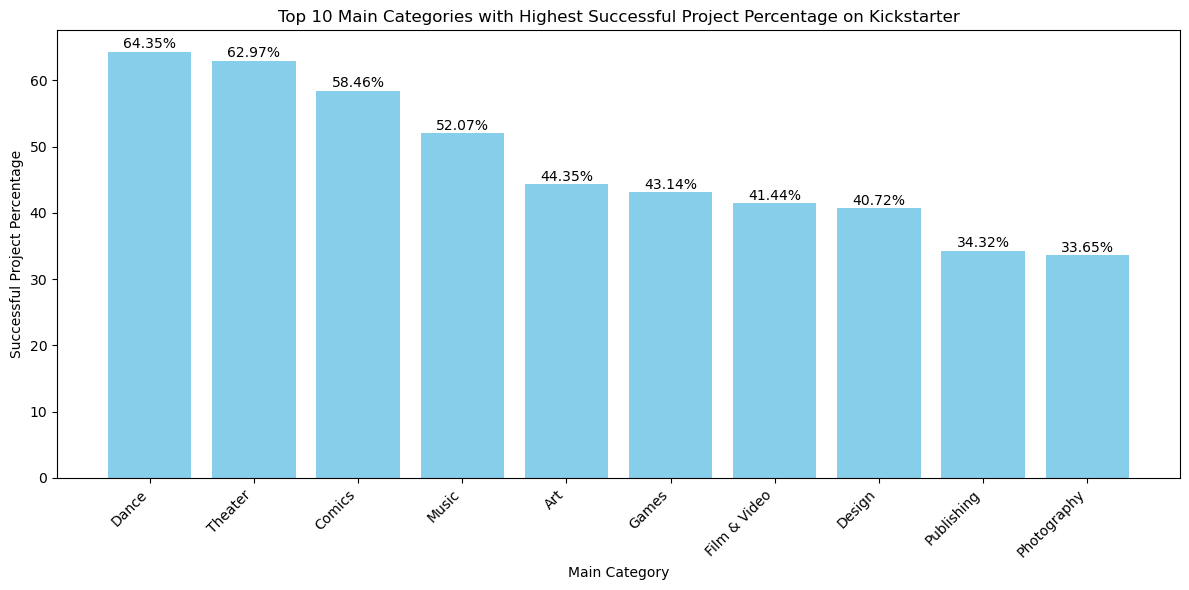

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert the PySpark DataFrame to a Pandas DataFrame for plotting
project_counts_pd = project_counts.toPandas()

# Sort the DataFrame by success_percentage
project_counts_pd = project_counts_pd.sort_values(by="success_percentage", ascending=False)

# Select the top 10 categories
top_10_categories = project_counts_pd.head(10)

# Plot the bar graph for the top 10 categories
plt.figure(figsize=(12, 6))
bars = plt.bar(top_10_categories["main_category"], top_10_categories["success_percentage"], color="skyblue")
plt.xlabel("Main Category")
plt.ylabel("Successful Project Percentage")
plt.title("Top 10 Main Categories with Highest Successful Project Percentage on Kickstarter")
plt.xticks(rotation=45, ha="right")

# Add data labels to each bar
for bar, label in zip(bars, top_10_categories["success_percentage"]):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f"{label:.2f}%", ha="center")

plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
b) Money raised (in USD Million) on Kickstarter by Main Category

In [15]:
from pyspark.sql import functions as F

# Select relevant columns for analysis
ks = ks0.select("main_category", "usd pledged")

# Group by main category and sum the money raised
category_totals = ks.groupBy("main_category").agg(F.sum("usd pledged").alias("total_money_raised"))

# Convert the PySpark DataFrame to a Pandas DataFrame for display
category_totals_pd = category_totals.toPandas()

# Sort the DataFrame by total money raised
category_totals_pd = category_totals_pd.sort_values(by="total_money_raised", ascending=False)

# Display the Pandas DataFrame
print(category_totals_pd)


    main_category  total_money_raised
90          Games        5.743213e+08
117        Design        5.119631e+08
132    Technology        5.028822e+08
29   Film & Video        3.458929e+08
116         Music        1.651574e+08
..            ...                 ...
283            PS                 NaN
285   Food Trucks                 NaN
301        Drinks                 NaN
302            TV                 NaN
304        People                 NaN

[320 rows x 2 columns]


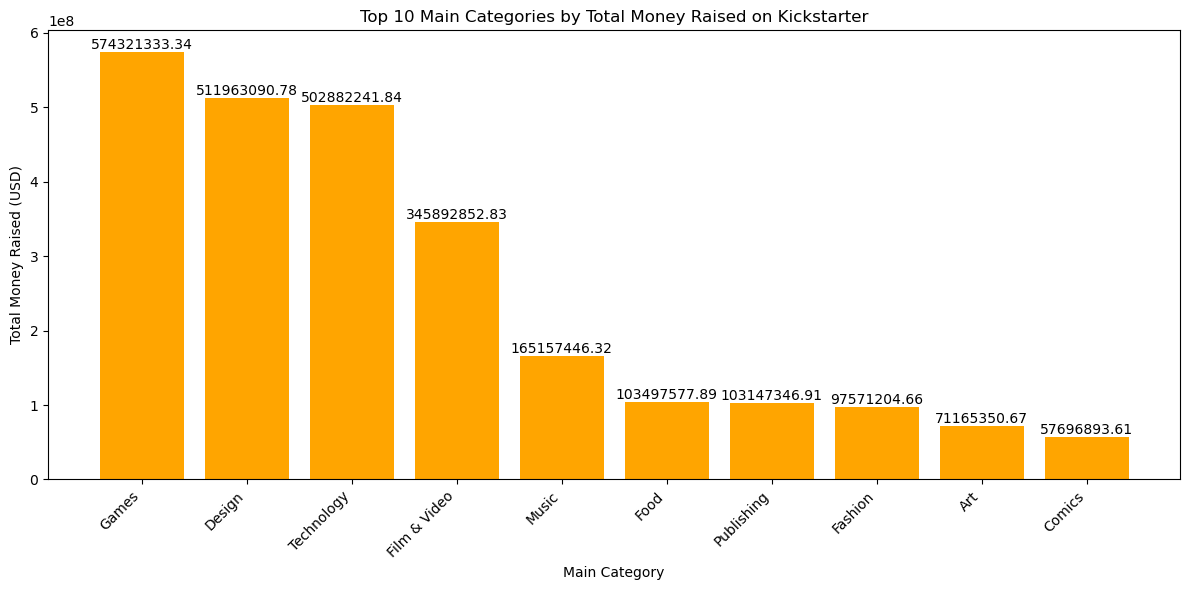

In [17]:
import matplotlib.pyplot as plt

# Select the top 10 categories
top_10_categories = category_totals_pd.head(10)

# Plot the bar chart with orange color
plt.figure(figsize=(12, 6))
bars = plt.bar(top_10_categories['main_category'], top_10_categories['total_money_raised'], color='orange')

# Add data labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom', color='black')

# Customize chart appearance
plt.title('Top 10 Main Categories by Total Money Raised on Kickstarter')
plt.xlabel('Main Category')
plt.ylabel('Total Money Raised (USD)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


                            Influence of Country on project success

In [ ]:
a) Top 10 Country by Successful project %

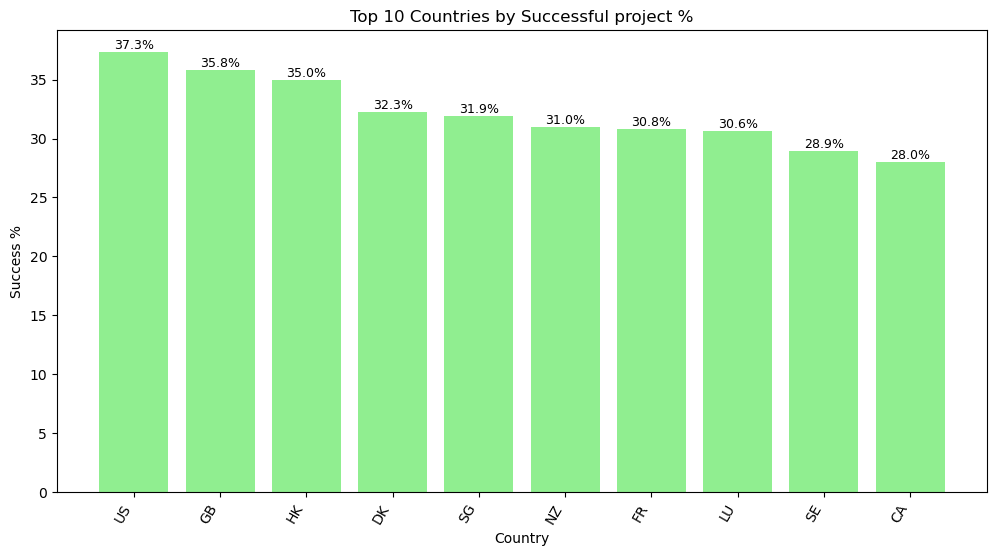

In [25]:
from pyspark.sql.window import Window

ks = spark.read.csv("gs://hivestoragesky/Updatedtable.csv", header=True)

# Group by country and state, and calculate frequency
ks3 = ks.groupBy("country", "state") \
        .agg(F.count("*").alias("freq"))

# Select relevant columns
ks3 = ks3.select("country", "freq", "state")

# Calculate country percentage
ks3 = ks3.withColumn("countryPerc", F.col("freq") / F.sum("freq").over(Window.partitionBy("country")))

# Filter for successful projects
ks3 = ks3.filter(ks3.state == "successful")

# Order by countryPerc in descending order
ks3 = ks3.orderBy(F.desc("countryPerc"))

# Select top 10 countries
ks33 = ks3.limit(10)

# Convert to Pandas for plotting
ks33_pd = ks33.toPandas()

# Plot the bar chart with data labels
plt.figure(figsize=(12, 6))
bars = plt.bar(ks33_pd["country"], ks33_pd["countryPerc"] * 100, color='lightgreen')
plt.xticks(rotation=60, ha='right')
plt.xlabel('Country')
plt.ylabel('Success %')
plt.title('Top 10 Countries by Successful project %')

# Add data labels
for bar, label in zip(bars, ks33_pd["countryPerc"] * 100):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{label:.1f}%', 
             ha='center', va='bottom', color='black', fontsize=9)

plt.show()


In [ ]:
b) Top 10 Country by Money raised (in USD Million)

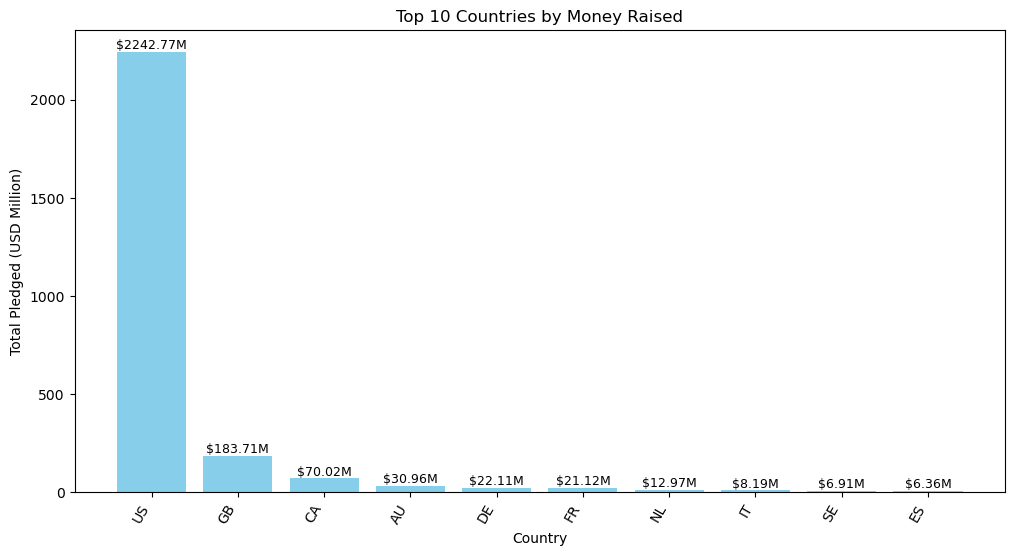

In [27]:
# Group by country and calculate the total pledged amount
ks_money = ks.groupBy("country") \
             .agg(F.sum("usd pledged").alias("total_pledged"))


# Order by total_pledged in descending order
ks_money = ks_money.orderBy(F.desc("total_pledged"))

# Select top 10 countries
ks_money_top10 = ks_money.limit(10)

# Convert to Pandas for plotting
ks_money_top10_pd = ks_money_top10.toPandas()

# Plot the bar chart with data labels
plt.figure(figsize=(12, 6))
bars = plt.bar(ks_money_top10_pd["country"], ks_money_top10_pd["total_pledged"] / 1e6, color='skyblue')
plt.xticks(rotation=60, ha='right')
plt.xlabel('Country')
plt.ylabel('Total Pledged (USD Million)')
plt.title('Top 10 Countries by Money Raised')

# Add data labels
for bar, label in zip(bars, ks_money_top10_pd["total_pledged"] / 1e6):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'${label:.2f}M', 
             ha='center', va='bottom', color='black', fontsize=9)

plt.show()


                        US vs Non-US influence on main category success

In [ ]:
a) Success project% by Main Category for US vs Non-US-via Data Table

In [38]:
from pyspark.sql.window import Window

# Define a window specification
window_spec = Window().orderBy(F.desc('freq'))

# Filter US data
ks_us = ks.filter(ks['country'] == 'US') \
    .groupBy('main_category', 'state') \
    .agg(F.count('*').alias('freq')) \
    .withColumn('US', F.col('freq') / F.sum('freq').over(window_spec)) \
    .filter(ks['state'] == 'successful') \
    .orderBy(F.desc('US'))

# Filter non-US data
ks_non_us = ks.filter(ks['country'] != 'US') \
    .groupBy('main_category', 'state') \
    .agg(F.count('*').alias('freq')) \
    .withColumn('NonUS', F.col('freq') / F.sum('freq').over(window_spec)) \
    .filter(ks['state'] == 'successful') \
    .orderBy(F.desc('NonUS'))

# Display the DataFrames
ks_us.show()
ks_non_us.show()


23/12/07 07:35:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/07 07:35:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/07 07:35:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/07 07:35:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/07 07:35:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/07 07:35:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/07 0

+-------------+----------+-----+--------------------+
|main_category|     state| freq|                  US|
+-------------+----------+-----+--------------------+
|        Music|successful|21565| 0.44395265054040145|
| Film & Video|successful|19686|  0.2883930795036697|
|   Publishing|successful| 9894| 0.05375567085925403|
|          Art|successful| 9456| 0.04886543917400044|
|        Games|successful| 9352|0.046100077392131636|
|       Design|successful| 7674|0.036449650180253354|
|         Food|successful| 5343|0.024749861033907725|
|      Theater|successful| 5171|0.023392791708700705|
|       Comics|successful| 4808|0.021287617495871318|
|   Technology|successful| 4717|0.020457463049059744|
|      Fashion|successful| 4116| 0.01657278375255175|
|  Photography|successful| 2530|0.009280180761781795|
|        Dance|successful| 2066|0.007458753023574...|
|       Crafts|successful| 1640|0.005778982123916881|
|   Journalism|successful|  797|0.002790860544515...|
+-------------+----------+--

23/12/07 07:35:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/07 07:35:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+-------------+----------+----+--------------------+
|main_category|     state|freq|               NonUS|
+-------------+----------+----+--------------------+
| Film & Video|successful|3834| 0.12611427255682378|
|        Games|successful|3161| 0.06722242306956171|
|       Design|successful|2866| 0.05744753352442422|
|        Music|successful|2474| 0.04724710196130856|
|   Publishing|successful|2327| 0.04254891204973487|
|          Art|successful|2012| 0.03296631275396513|
|   Technology|successful|1710|0.027254470689490294|
|      Fashion|successful|1472|0.021784815746633122|
|      Theater|successful|1304| 0.01856174913169732|
|       Comics|successful|1019|0.013840219487680981|
|  Photography|successful| 761|0.009794457958479736|
|         Food|successful| 735|0.009371175030599756|
|       Crafts|successful| 475|0.005791764720227281|
|        Dance|successful| 250|0.003011322572874...|
|   Journalism|successful| 214|0.002556139512661252|
+-------------+----------+----+---------------

23/12/07 07:35:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/07 07:35:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [ ]:
b)Success project% by Main Category for US vs Non-US-via Graph

23/12/07 07:31:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/07 07:31:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/07 07:31:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/07 07:31:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/07 07:31:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/07 07:31:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/07 0

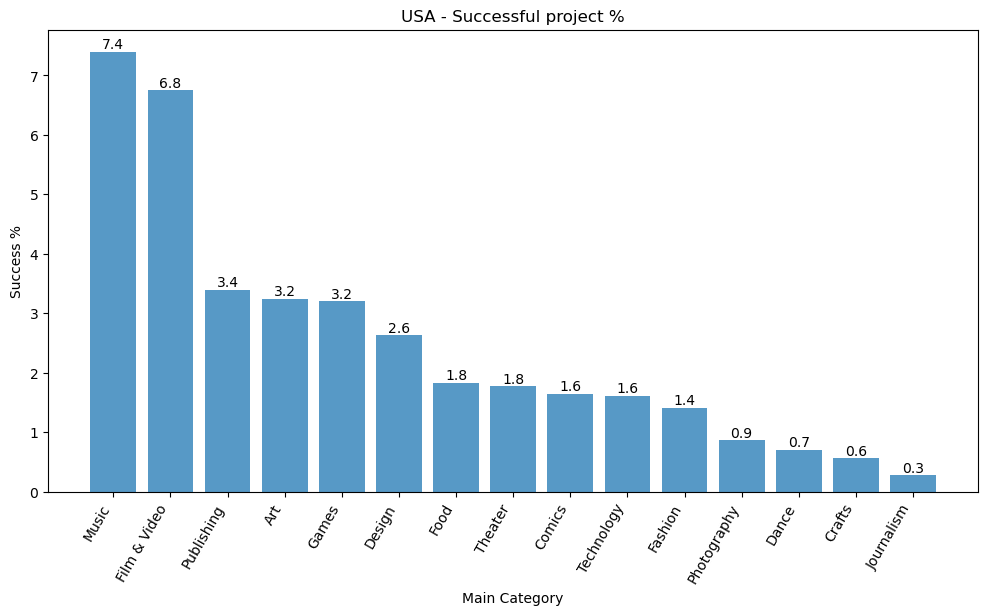

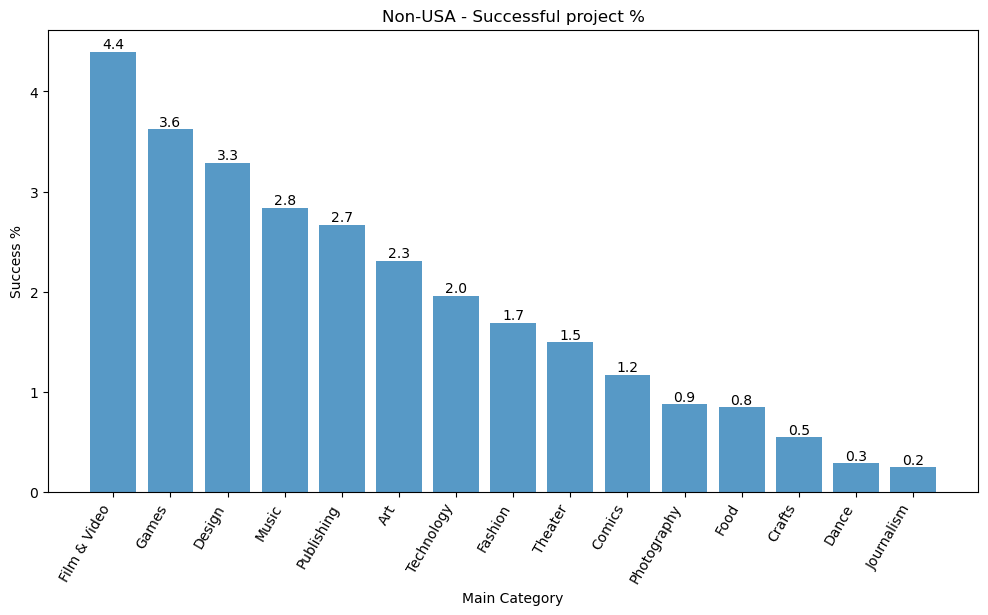

In [36]:
from pyspark.sql.window import Window

# Define a Window specification
window_spec = Window().orderBy()

# Filter for US projects
ks_us = ks.filter(ks['country'] == 'US') \
    .groupBy('main_category', 'state') \
    .agg(F.count('*').alias('freq')) \
    .withColumn('US', F.col('freq') / F.sum('freq').over(window_spec)) \
    .filter(ks['state'] == 'successful') \
    .orderBy(F.desc('US'))

# Select relevant columns
USsuccess = ks_us.select('main_category', 'US')

# Filter for non-US projects
ks_non_us = ks.filter(ks['country'] != 'US') \
    .groupBy('main_category', 'state') \
    .agg(F.count('*').alias('freq')) \
    .withColumn('NonUS', F.col('freq') / F.sum('freq').over(window_spec)) \
    .filter(ks['state'] == 'successful') \
    .orderBy(F.desc('NonUS'))

# Select relevant columns
NonUSsuccess = ks_non_us.select('main_category', 'NonUS')

# Plotting with Matplotlib (PySpark doesn't have native plotting functions)
import matplotlib.pyplot as plt

# Convert PySpark DataFrames to Pandas for plotting
ks_us_pd = USsuccess.toPandas()
ks_non_us_pd = NonUSsuccess.toPandas()

# Plot for US projects
plt.figure(figsize=(12, 6))
bars = plt.bar(ks_us_pd['main_category'], ks_us_pd['US'] * 100, alpha=0.75)
plt.xticks(rotation=60, ha='right')
plt.xlabel('Main Category')
plt.ylabel('Success %')
plt.title('USA - Successful project %')

# Add data labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), ha='center', va='bottom')

plt.show()

# Plot for non-US projects
plt.figure(figsize=(12, 6))
bars = plt.bar(ks_non_us_pd['main_category'], ks_non_us_pd['NonUS'] * 100, alpha=0.75)
plt.xticks(rotation=60, ha='right')
plt.xlabel('Main Category')
plt.ylabel('Success %')
plt.title('Non-USA - Successful project %')

# Add data labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), ha='center', va='bottom')

plt.show()


                    Relationship between amount pledged and number of backers on Kickstarter

In [ ]:
a) Scatter plot of pledged amount vs number of backers

23/12/07 08:24:54 WARN Instrumentation: [d1aecb78] regParam is zero, which might cause numerical instability and overfitting.


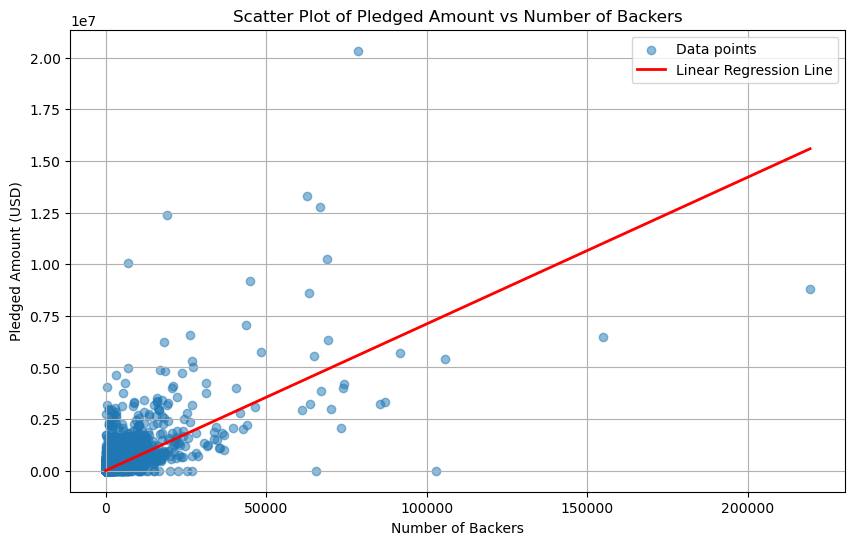

In [4]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import StructType, StructField, DoubleType

# Select relevant columns and convert "backers" and "pledged" to numeric
scatter_data = ks.select(col("backers").cast("double"), col("pledged").cast("double"))

# Drop rows with missing values
scatter_data = scatter_data.dropna()

# Convert the DataFrame to Pandas for plotting
scatter_pd = scatter_data.toPandas()

# Plot the scatter plot using matplotlib
plt.figure(figsize=(10, 6))
plt.scatter(scatter_pd["backers"], scatter_pd["pledged"], alpha=0.5, label='Data points')

# Use VectorAssembler to prepare features for linear regression
vec_assembler = VectorAssembler(inputCols=["backers"], outputCol="features")
scatter_data = vec_assembler.transform(scatter_data)

# Train a linear regression model
lr = LinearRegression(featuresCol='features', labelCol='pledged')
lr_model = lr.fit(scatter_data)

# Define a schema for the new DataFrame
schema = StructType([StructField("backers", DoubleType(), True)])

# Create a DataFrame with the specified schema
x_range_df = spark.createDataFrame([(float(x),) for x in x_range], schema=schema)

# Transform the new DataFrame using the trained model
y_pred = lr_model.transform(vec_assembler.transform(x_range_df))

# Plot the linear regression line
plt.plot(x_range, y_pred.select("prediction").toPandas(), color='red', linewidth=2, label='Linear Regression Line')

plt.title("Scatter Plot of Pledged Amount vs Number of Backers")
plt.xlabel("Number of Backers")
plt.ylabel("Pledged Amount (USD)")
plt.legend()
plt.grid(True)
plt.show()

# Stop the Spark session
spark.stop()
